### Plot the altimeters from the Bar and Trough sites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# colors from ColorBrewer
purples = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']
oranges = ['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']

pathn = r'C:\\crs\\proj\\2019_DUNEX\\Pea_Island_Data\\01_Nearshore\\'

# Choose site by changing comments
#site = 'Bar'
site = 'Trough'

if site == 'Bar':
    fn = 'aa400_0074_orange_raw_trim.txt'
    figfn = 'orange_bar_altimeter_plot.png'
    zylims = [1., 0.]
    dzylims = [-2, 2]
    col = oranges[2]

if site == 'Trough':
    fn = 'aa400_0084_purple_raw_trim.txt'
    figfn = 'purple_trough_altimeter_plot.png'
    zylims = [1., 0.]
    dzylims = [-2, 2]
    col = purples[3]

# number of samples in each burst
burstn = 10

# smoothing window (number of samples...in this case, smooth over 13 hours)
win = 13*6+1

#### Read the file into memory and strip leading white space

In [2]:
with open(pathn+fn) as file:
    lines = file.readlines()

# Strip leading white space. Note we are skipping first line, which has column titles
lines = [line.rstrip() for line in lines][1:]

#### Parse the lines. Dates and times will be in lists; values will be in arrays

In [3]:
dates = [line.split()[0] for line in lines]
times = [line.split()[1] for line in lines]
alts =  np.asarray([line.split()[3] for line in lines], dtype=np.float32)
temps = np.asarray([line.split()[4] for line in lines], dtype=np.float32)
batts = np.asarray([line.split()[5] for line in lines], dtype=np.float32)
amps =  np.asarray([line.split()[6] for line in lines], dtype=np.float32)

#### Reshape the arrays to 2D array with [number of bursts, burstn], then calculate selected statistics for each burst

In [4]:
altmax = np.max( np.reshape(alts,(len(times)//burstn,burstn)), 1 )
altstd = np.std( np.reshape(alts,(len(times)//burstn,burstn)), 1 )
ampmax = np.max( np.reshape(amps,(len(times)//burstn,burstn)), 1 )
ampmn = np.mean( np.reshape(amps,(len(times)//burstn,burstn)), 1 )
ampstd = np.std( np.reshape(amps,(len(times)//burstn,burstn)), 1 )
temps = np.mean( np.reshape(temps,(len(times)//burstn,burstn)), 1 )

#### Create an array of datetime objects  and select the start time of each burst
There should be a way to do this without using append

In [5]:
dt = []
for s in zip(dates, times):
    dt.append( datetime.datetime.strptime( s[0]+' '+s[1], '%Y%m%d %H:%M:%S.%f') )    

# dts is the array of start times
dts = np.reshape(dt,(len(times)//burstn,burstn))[:,1]

In [6]:
# Replace zeros with NaN
altmax[altmax<.001]=np.nan

# Conversion factor from meters per 10 min to cm/h
tfac = 3600./6000.
dzdt = -np.diff(tfac*altmax)
dzdts = np.convolve(dzdt, np.ones(win) / (win), mode="same")

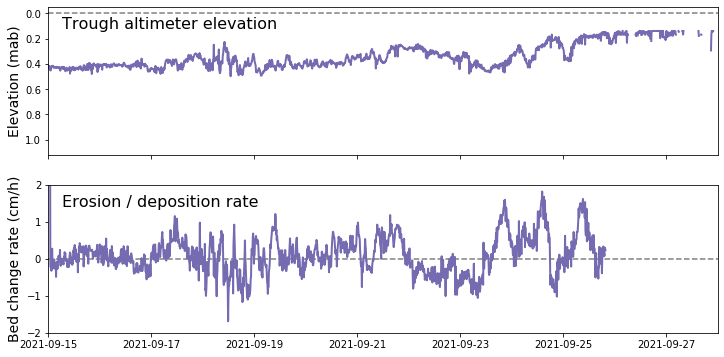

In [7]:
dstart = datetime.date(2021, 9, 15)
dend = datetime.date(2021, 9, 28)

fig, ax = plt.subplots(nrows=2, ncols=1, sharey=False, sharex=True, squeeze=True, figsize = (12,6))
ax[0].plot([dstart,dend],[0., 0.],'--',c='gray',zorder=0)
ax[0].plot(dts,altmax/1000,'-',linewidth=2,c=col,zorder=1)
ax[0].invert_yaxis()
ax[0].set_xlim([dstart, dend])
#ax[0].set_ylim(zylims)
ax[0].set_ylabel('Elevation (mab)',fontsize=14)
ax[0].text(.02,.85,site+' altimeter elevation',fontsize=16,transform=ax[0].transAxes)
ax[0].set_xticklabels([])

ax[1].plot([dstart,dend],[0., 0.],'--',c='gray',zorder=0)
ax[1].plot(dts[1:],dzdts,linewidth=2,c=col,zorder=1)
ax[1].set_xlim([dstart, dend])
ax[1].set_ylim(dzylims)
ax[1].set_ylabel('Bed change rate (cm/h)',fontsize=14)
ax[1].text(.02,.85,'Erosion / deposition rate',fontsize=16,transform=ax[1].transAxes)
plt.savefig(pathn+figfn)